PART 1: Preliminary data analysis

In [28]:
from keras import layers, regularizers
from keras.optimizers import SGD, Adagrad
from keras.layers import Flatten, Conv1D, MaxPooling1D, Dense
from keras import backend as K
from keras.models import Sequential
import tensorflow as tf
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score,\
    roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.utils import class_weight
from imblearn.combine import SMOTETomek
from sklearn.utils import resample
import importlib
import warnings

In [29]:
df = pd.read_csv ('Data/bank_data_prediction_task.csv', low_memory=False)
print(df.head(10))

   Unnamed: 0  age          job  marital    education  default housing loan  \
0           1   37     services  married  high.school       no     yes   no   
1           2   56     services  married  high.school       no      no  yes   
2           3   41  blue-collar  married      unknown  unknown      no   no   
3           4   25     services   single  high.school       no     yes   no   
4           5   25     services   single  high.school       no     yes   no   
5           6   35  blue-collar  married     basic.6y       no     yes   no   
6           7   54      retired  married     basic.9y  unknown     yes  yes   
7           8   46  blue-collar  married     basic.6y  unknown     yes  yes   
8           9   41   technician   single  high.school       no     yes   no   
9          10   37       admin.  married  high.school       no     yes   no   

     contact month  ... pdays  previous     poutcome  emp.var.rate  \
0  telephone   may  ...   999         0  nonexistent        

In [30]:
df.describe()

,Unnamed: 0,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.00000,16476.000000,16476.000000,41188.000000,41188.000000,41188.000000,40938.000000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.02406,259.660172,2.546856,962.475454,0.172963,0.081886,93.575950,-40.502600,3.621291,5167.035911
std,11890.09578,10.42125,260.660561,2.699664,186.910907,0.494901,1.570960,0.578889,4.628198,1.734447,72.251528
min,1.00000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,10297.75000,32.00000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,20594.50000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,30891.25000,47.00000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,41188.00000,98.00000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [31]:
df.dtypes

Unnamed: 0             int64
age                    int64
job                   object
marital               object
education             object
default               object
housing               object
loan                  object
contact               object
month                 object
day_of_week           object
duration             float64
campaign             float64
pdays                  int64
previous               int64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
y                     object
test_control_flag     object
dtype: object

In [32]:
df.isnull().sum()

Unnamed: 0               0
age                      0
job                      0
marital                  0
education                0
default                  0
housing                  0
loan                     0
contact              24712
month                24712
day_of_week          24712
duration             24712
campaign             24712
pdays                    0
previous                 0
poutcome                 0
emp.var.rate             0
cons.price.idx         250
cons.conf.idx            0
euribor3m                0
nr.employed              0
y                        0
test_control_flag        0
dtype: int64

In [33]:
df['job']=df['job'].map({job: x for x, job in enumerate(df['job'].unique())})
df['marital']=df['marital'].map({job: x for x, job in enumerate(df['marital'].unique())})
df['education']=df['education'].map({job: x for x, job in enumerate(df['education'].unique())})
df['default']=df['default'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['housing']=df['housing'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['loan']=df['loan'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['contact']=df['contact'].map({job: x for x, job in enumerate(df['contact'].unique())})
df['month']=df['month'].map({job: x for x, job in enumerate(df['month'].unique())})
df['day_of_week']=df['day_of_week'].map({job: x for x, job in enumerate(df['day_of_week'].unique())})
df['poutcome']=df['poutcome'].apply(lambda x: 2 if x == "success" else (0 if x == "failure" else 1))
df['y']=df['y'].apply(lambda x: 1 if x == "yes" else 0)
df['cons.price.idx'] = df['cons.price.idx'].fillna(df['cons.price.idx'].median())
print(df.dtypes)

Unnamed: 0             int64
age                    int64
job                    int64
marital                int64
education              int64
default                int64
housing                int64
loan                   int64
contact                int64
month                  int64
day_of_week            int64
duration             float64
campaign             float64
pdays                  int64
previous               int64
poutcome               int64
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
y                      int64
test_control_flag     object
dtype: object


In [34]:
df.groupby(['test_control_flag'])['test_control_flag'].count()

test_control_flag
campaign group    16476
control group     24712
Name: test_control_flag, dtype: int64

In [35]:
df_Control_group=df[df['test_control_flag']=="control group"]
Control_results=df_Control_group.groupby(['y'])['y'].count()
Control_percentage_results=(Control_results / Control_results.sum()) * 100
print("Clients from control group did not subscribed a term deposit: "
      + str(round(Control_results[0]))
      + " ("+str(round(Control_percentage_results[0],2))+"%)")
print("Clients from control group subscribed a term deposit: "
            + str(round(Control_results[1]))
      + " ("+str(round(Control_percentage_results[1],2))+"%)")

Clients from control group did not subscribed a term deposit: 22028 (89.14%)
Clients from control group subscribed a term deposit: 2684 (10.86%)


In [36]:
df_Campaign_group=df[df['test_control_flag']=="campaign group"]
Campaign_results=df_Campaign_group.groupby(['y'])['y'].count()
Campaign_percentage_results=(Campaign_results / Campaign_results.sum()) * 100
print("Clients from campaign group did not subscribed a term deposit: "
      + str(round(Campaign_results[0]))
      + " ("+str(round(Campaign_percentage_results[0],2))+"%)")
print("Clients from campaign group subscribed a term deposit: "
      + str(round(Campaign_results[1]))
      + " ("+str(round(Campaign_percentage_results[1],2))+"%)")

Clients from campaign group did not subscribed a term deposit: 13992 (84.92%)
Clients from campaign group subscribed a term deposit: 2484 (15.08%)


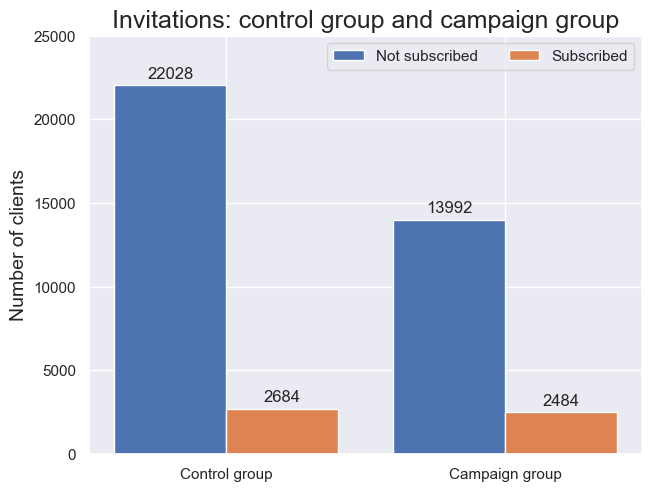

In [37]:
types = ("Control group", "Campaign group")
values = {
    'Not subscribed': (Control_results[0], Campaign_results[0]),
    'Subscribed': (Control_results[1], Campaign_results[1]),
}

x = np.arange(len(types))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Number of clients', fontsize=14)
ax.set_title('Invitations: control group and campaign group', fontsize=18)
ax.set_xticks(x + width/2, types)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 25000)

plt.show()

PART 2: Data cleaning and analysis using ML

In [38]:
X_train, y_train=df_Control_group.iloc[:, :-2],df_Control_group["y"]
X_train.drop(columns=['Unnamed: 0','contact', 'month','day_of_week','duration','campaign'], inplace=True)
X_test, y_test=df_Campaign_group.iloc[:, :-2],df_Campaign_group["y"]
X_test.drop(columns=['Unnamed: 0','contact', 'month','day_of_week','duration','campaign'], inplace=True)

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_train

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
16476,0.481481,0.727273,0.000000,0.714286,0.0,0.0,0.0,1.000000,0.000000,0.5,0.937500,0.698753,0.60251,0.957379,0.859735
16477,0.493827,0.000000,0.000000,0.000000,0.5,0.0,0.0,1.000000,0.000000,0.5,0.937500,0.698753,0.60251,0.957379,0.859735
16478,0.283951,0.363636,0.000000,0.285714,0.0,0.0,0.0,1.000000,0.000000,0.5,0.937500,0.698753,0.60251,0.957379,0.859735
16479,0.345679,0.000000,0.000000,0.428571,0.5,0.0,0.0,1.000000,0.000000,0.5,0.937500,0.698753,0.60251,0.957379,0.859735
16480,0.518519,0.363636,0.000000,0.857143,0.0,0.0,0.0,1.000000,0.000000,0.5,0.937500,0.698753,0.60251,0.957379,0.859735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.148148,0.636364,0.333333,0.714286,0.0,1.0,0.0,0.009009,0.166667,1.0,0.479167,1.000000,0.00000,0.089322,0.000000
41184,0.358025,0.090909,0.000000,0.857143,0.0,0.0,0.0,1.000000,0.000000,0.5,0.479167,1.000000,0.00000,0.089322,0.000000
41185,0.481481,0.181818,0.000000,0.571429,0.0,1.0,0.0,1.000000,0.000000,0.5,0.479167,1.000000,0.00000,0.089322,0.000000
41186,0.333333,0.272727,0.000000,0.857143,0.0,0.0,0.0,1.000000,0.000000,0.5,0.479167,1.000000,0.00000,0.089322,0.000000


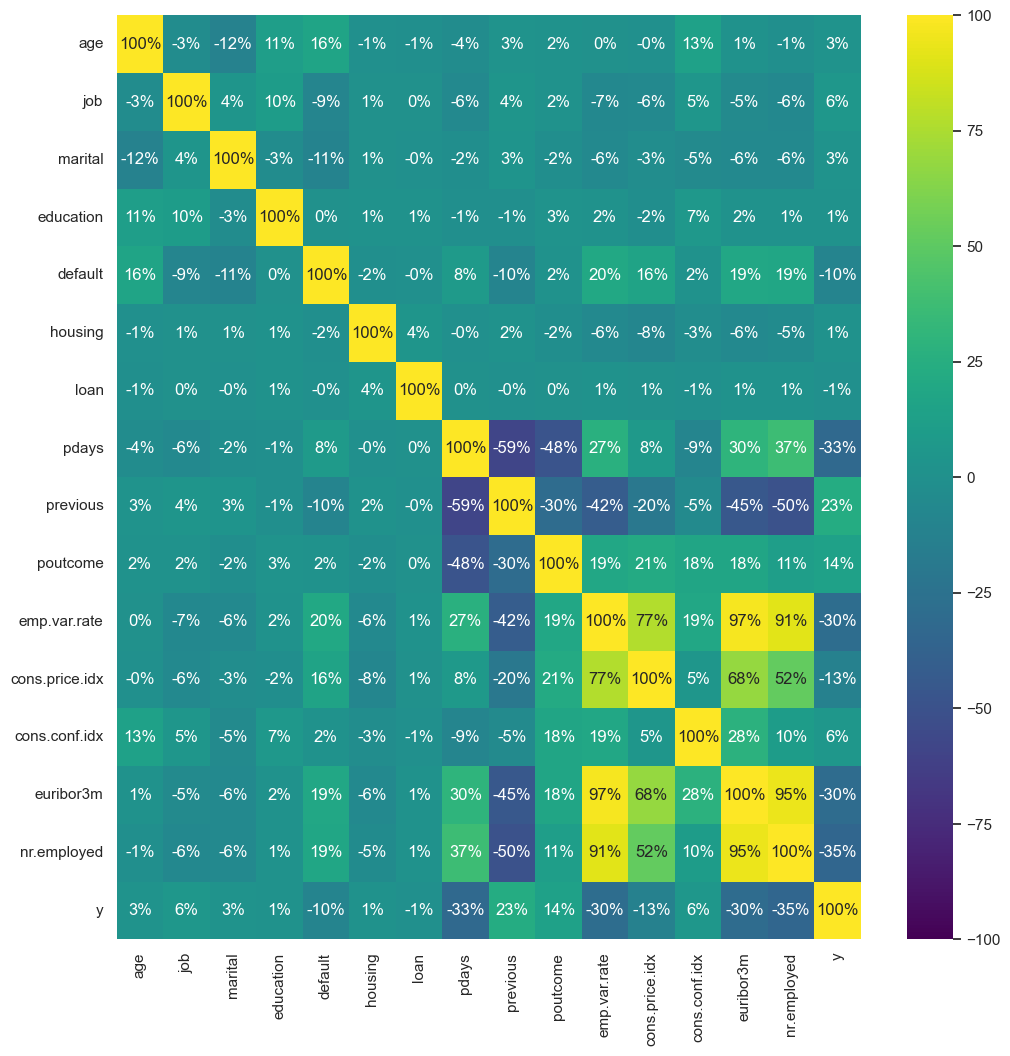

In [40]:
sns.set()
Train=X_train
Train['y']=y_train
fig, ax0 = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(Train.corr()*100, vmin=-100, vmax=100, annot=True, fmt=".0f", cmap='viridis')
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()